# Question

What is the mapping between the filters used in the parallel-processing model and the true filters of a HH neuron?

# Functions for the toy HH model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigma(x):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-x))

def minf(v):
    """Equilibrium state of the Na activation gate."""
    return sigma(v-10)

def hinf(v):
    """Equilibrium state of the Na inactivation gate."""
    return sigma(-(v-5))

def dm(v, m):
    """Derivative of the Na activation gate state."""
    tau = 0.5
    return (minf(v) - m)/tau

def dh(v, h):
    """Derivative of the Na inactivation gate state."""
    tau = 10. if v < 12 else 1.
    return (hinf(v) - h)/tau

def dv(I, v, m, h):
    """Derivative of membrane voltage."""
    gl = 0.05  # Size of leak conductance
    gNa = 10  # Size of sodium conductance
    C = 0.1  # Membrane capacitance
    return I/C - v * gl/C + gNa * m * h/C

Integrate the dynamics of the toy HH neuron.

In [3]:
np.random.seed(43)  # Set random seed for reproducibility
input_ = np.random.normal(0, 1, size = 1000)
dt = 0.1

# Set initial conditions
V = 0
m = minf(V)
h = hinf(V)

# Integrate dynamics
voltages = []
ms = []
hs = []
for in_ in input_:
    voltages.append(V)
    ms.append(m)
    hs.append(h)
    
    new_m = m + dm(V, m)*dt
    new_h = h + dh(V, h)*dt
    new_V = V + dv(in_, V, m, h)*dt
    
    m = new_m
    h = new_h
    V = new_V

Plot toy HH neuron dynamics.

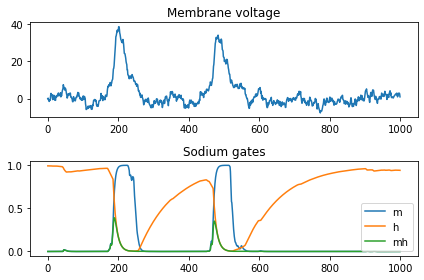

In [4]:
plt.subplot(211)
plt.title('Membrane voltage')
plt.plot(voltages)

plt.subplot(212)
plt.title('Sodium gates')
plt.plot(ms, label='m')
plt.plot(hs, label='h')
plt.plot(np.asarray(ms) * np.asarray(hs), label='mh')
plt.legend()
plt.tight_layout()

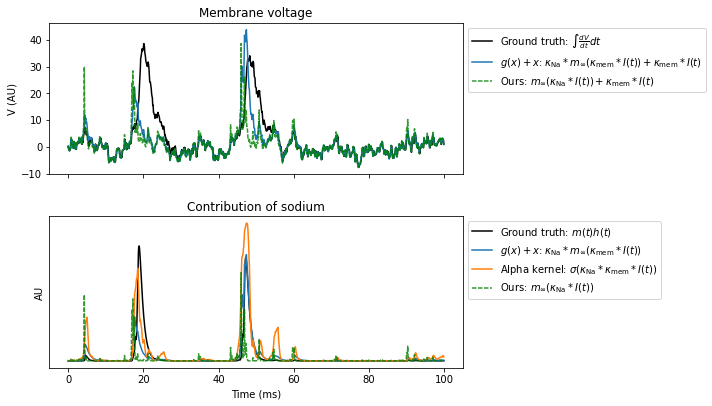

In [5]:
x = np.arange(0, 50, dt)
membrane_filter = np.exp(-x/2)
na_filter = np.exp(-x/1)

predicted_v_passive = np.convolve(membrane_filter, input_, mode='full')[:len(input_)]
predicted_v_na = np.convolve(na_filter, minf(predicted_v_passive), mode='full')[:len(input_)]
our_v_na = minf(np.convolve(na_filter, input_, mode='full')[:len(input_)])

time_ = np.arange(0, len(input_) * dt, dt)

plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.title('Membrane voltage')
plt.plot(time_, voltages, 'k-', label='Ground truth: $\int \\frac{dV}{dt} dt$')
plt.plot(time_, predicted_v_passive + 50 * predicted_v_na, label='$g(x) + x$: $\kappa_\mathrm{Na} * m_\infty(\kappa_\mathrm{mem} * I(t)) + \kappa_\mathrm{mem} * I(t)$')
plt.plot(time_, predicted_v_passive + 1000 * our_v_na, 'g--', dashes=(3, 1), alpha=0.8, label='Ours: $m_\infty(\kappa_\mathrm{Na} * I(t)) + \kappa_\mathrm{mem} * I(t)$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('V (AU)')
plt.gca().set_xticklabels([])

plt.subplot(312)
plt.title('Contribution of sodium')
plt.plot(time_, np.asarray(ms) * np.asarray(hs), 'k-', label='Ground truth: $m(t)h(t)$')
plt.plot(time_, predicted_v_na / 2, label='$g(x) + x$: $\kappa_\mathrm{Na} * m_\infty(\kappa_\mathrm{mem} * I(t))$')
plt.plot(time_, 0.5 * sigma(np.convolve(np.convolve(na_filter, membrane_filter, mode='full')[:len(membrane_filter)], input_, mode='full')[:len(input_)]/8 - 6),
        label='Alpha kernel: $\sigma(\kappa_\mathrm{Na} * \kappa_\mathrm{mem} * I(t))$')
plt.plot(time_, our_v_na * 10, 'g--', dashes=(3, 1), alpha=0.8, label='Ours: $m_\infty(\kappa_\mathrm{Na} * I(t))$')

plt.yticks([])
plt.ylabel('AU')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.savefig('/Users/efharkin/Desktop/model_comparison.png', dpi=200)

# Failed experiments beyond this point

In [10]:
def recurse(predicted_v, depth, scaling_factor):
    predicted_v_na = np.convolve(
        membrane_filter, 
        np.convolve(na_filter, minf(predicted_v[:-depth]), mode='full')[:len(predicted_v-depth]
    )[:len(predicted_v-depth)]
    predicted_v_na = np.concatenate([np.zeros(depth)])
    if depth != 0:
        return recurse(predicted_v + scaling_factor * predicted_v_na, depth-1, scaling_factor)
    else:
        return predicted_v + scaling_factor * predicted_v_na

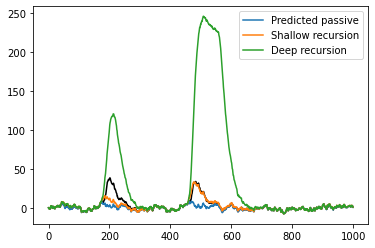

In [23]:
plt.plot(voltages, 'k-')
plt.plot(predicted_v_passive, label='Predicted passive')
plt.plot(recurse(predicted_v_passive, 0, 4), label='Shallow recursion')
plt.plot(recurse(predicted_v_passive, 2, 1), label='Deep recursion')
plt.legend()

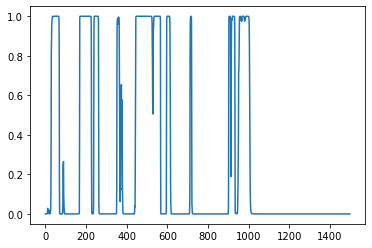

In [110]:
plt.plot(minf(np.convolve(na_filter, predicted_v_passive, mode='full')))

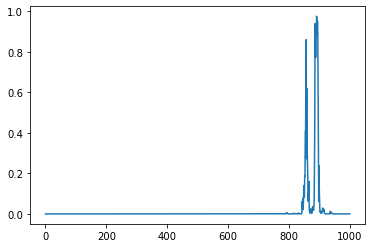

In [16]:
plt.plot(minf(predicted_v_passive))